In [6]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.utils import np_utils, generic_utils
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers import Embedding,GRU,TimeDistributed,RepeatVector,Merge
from keras.preprocessing.text import one_hot
from keras.preprocessing import sequence
import cv2
import numpy as np
from vgg16 import Vgg16

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import PIL.Image

import json
from tqdm import tqdm

from keras.optimizers import SGD, RMSprop, Adam

from utils import *
import cPickle as pickle
from matplotlib import pyplot as plt


In [7]:
class ImageData(object):

    def __init__(self,id,name):
        self.id = id
        self.name = name
        self.captions = []
        self.image = []
        
    def appendCaption(self,caption):
        self.captions.append(caption)
        
class ImageEntry(object):

    def __init__(self,image,caption):
        self.image = image
        self.caption = caption
        
              

# Data Building

In [8]:
def build_data_dict():
    annotation_path = "/home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/raw_annotations/captions_val2014.json"
    with open(annotation_path) as data_file:    
        data = json.load(data_file)
        
    id2ImageDataDict = {imageJson["id"]: ImageData(imageJson["id"],imageJson["file_name"]) 
                        for imageJson in data["images"]}
    
    annotationsJson = data["annotations"]
    
    for annotationJson in annotationsJson:
        imageData = id2ImageDataDict[annotationJson["image_id"]]
        caption = annotationJson["caption"]
        imageData.appendCaption(caption)

    fileName2ImageDataDict = {imageJson["file_name"]: id2ImageDataDict[imageJson["id"]] for imageJson in data["images"]}

    return fileName2ImageDataDict

def construct_image_data_arr(base_path,fileName2ImageDataDict):   
    
    image_paths = [f for f in listdir(base_path)]
    
    
    for image_file_name in tqdm(image_paths):
        
        img = PIL.Image.open(base_path+"/"+image_file_name)
        img = img.resize((224, 224), PIL.Image.NEAREST)
        
        image_data = fileName2ImageDataDict[image_file_name]
        
        img = np.asarray(img)
        
        image_data.image = img
        image_data.image = np.asarray(image_data.image)
        
        
        
    all_image_data = [imageData for _,imageData in fileName2ImageDataDict.iteritems()]
    
    filtered_image_data = [imageData for imageData in all_image_data
                      if np.asarray(imageData.image).shape == (224,224,3)]
    

    return  filtered_image_data

def constructImageEntryArr(imageDataArr):
    image_entry_arr = []

    for imageData in imageDataArr:
        image = imageData.image

        for caption in imageData.captions:
            image_entry_arr.append(ImageEntry(image,caption))

    return image_entry_arr

def construct_images_concat_t(image_data_arr):
    image_np_arr = [ np.expand_dims(image_data.image, axis=0) for image_data in image_data_arr]
    images_concat =  np.vstack(image_np_arr)
    images_concat_t = np.transpose(images_concat,(0,3,1,2))
    return images_concat_t


def get_unique_words(captions):
    unique_words = []
    words = [caption.split() for caption in captions]
   
    for word in words:
        unique_words.extend(word)
        
    unique_words = list(set(unique_words))
    
    return unique_words

def get_index_word_dicts(unique_words):
    word_index = {}
    index_word = {}
    for i,word in enumerate(unique_words):
        word_index[word] = i
        index_word[i] = word
        
    return (word_index,index_word)

def get_train_captions_indexed(captions, word2index, MAX_CAPTION_LEN ):
    
    train_captions_indexed = []
    for caption in captions:
        one = [word2index[caption_word] for caption_word in caption.split()]
        train_captions_indexed.append(one)

    train_captions_indexed = sequence.pad_sequences(train_captions_indexed, maxlen=MAX_CAPTION_LEN,padding='post')
    return train_captions_indexed
    
    

In [9]:
def get_captions_from_batch(batch_nr):
    captions = pickle.load(open(captions_path+"val2014_captions_"+str(batch_nr)+".p", "rb" ))
    return captions

def get_truncated_captions_from_batch(batch_nr,nr_instances):
    captions = get_captions_from_batch(batch_nr)
    captions = captions[:nr_instances]
    return captions

def dump_captions_to_disk(image_data_arr):
    for i in tqdm(range(5)):
        captions = ["START "+image_data.captions[i]+" END" for image_data in image_data_arr] 
        pickle.dump( captions, open(captions_path+"val2014_captions_"+str(i)+".p", "wb" ) )
        
        
def compute_partial_all_words_2_next_word(captions_indexed,step_size,np_save_path):
    
    for window_start in tqdm(range(0,len(captions_indexed),step_size)):
    
        captions_indexed_batch = captions_indexed[window_start:window_start+step_size]

        all_words_2_next_word = []

        for caption_indexed in captions_indexed_batch:

            word_2_next_word = []

            enhanced_caption_indexed = np.append(caption_indexed,[word2index["END"]]) #hacky

            for i in xrange(0,len(caption_indexed)):
                caption_word_index = enhanced_caption_indexed[i]
                future_word_index = enhanced_caption_indexed[i+1]
                future_indexes = np.zeros(VOCAB_SIZE)
                future_indexes[future_word_index] = 1

                word_2_next_word.append(future_indexes)

            words_2_next_word = np.vstack(word_2_next_word)

            all_words_2_next_word.append(words_2_next_word)

        save_array(np_save_path+ 'all_words_2_next_word__'+str(format(window_start, "06"))+'.bc', all_words_2_next_word)
    
def get_future_words(np_save_path):
    all_words_2_next_word_paths= [f for f in listdir(np_save_path)]
    all_words_2_next_word_paths.sort()

    all_words_2_next_word = [load_array(np_save_path + all_words_2_next_word_path) 
                             for all_words_2_next_word_path in all_words_2_next_word_paths ]

    future_words = np.vstack(all_words_2_next_word)
    future_words = np.transpose(future_words,(0,1,2))
    return future_words

In [10]:
save_path = "/home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/"
images_path = save_path+"raw_images/val2014"
image_data_arr_path = save_path+"imageDataArr/"
images_concat_t_path = save_path+"imagesConcatT/"
captions_path = save_path+"captions/"
np_save_path = save_path+"temp/"
model_path = save_path+"models/"
images_vgg_features_path = save_path + "images_vgg_features/"

NR_INSTANCES = 1000

# Raw Images

In [ ]:
fileName_2_image_data_dict = build_data_dict()

In [ ]:
image_data_arr = construct_image_data_arr(images_path,fileName_2_image_data_dict)

In [41]:
# train_images_concat_t = construct_images_concat_t(image_data_arr)
train_images_concat_t = load_array(images_concat_t_path + 'val_imagesConcatT_1000.bc')

In [11]:
test_images_concat_t = load_array(images_concat_t_path+'val_imagesConcatT_last_1000.bc')

In [ ]:
# save_array(images_concat_t_path+ 'val_imagesConcatT.bc', imagestConcatT)

In [ ]:
# NR_INSTANCES = len(imagestConcatT)

In [42]:
train_images_concat_t = train_images_concat_t[:NR_INSTANCES]
print(train_images_concat_t.shape)


(1000, 3, 224, 224)


# Precomputeg VGG Features

In [12]:
images_precomputed_vgg_features = load_array(images_vgg_features_path+'images_vgg_features.bc')
images_precomputed_vgg_features = images_precomputed_vgg_features[:NR_INSTANCES]
test_images_precomputed_vgg_features = load_array(images_vgg_features_path+'images_vgg_features_last_1000.bc')

In [13]:
print(images_precomputed_vgg_features.shape)
print(test_images_precomputed_vgg_features.shape)

(1000, 4096)
(1000, 4096)


# Captions

In [14]:
captions = get_truncated_captions_from_batch(batch_nr = 0, nr_instances = NR_INSTANCES )
# captions = get_captions_from_batch(batch_nr = 0)
len(captions)

1000

In [15]:
MAX_CAPTION_LEN = max([len(caption.split()) for caption in captions])
MAX_CAPTION_LEN

30

In [16]:
unique_words = get_unique_words(captions)
VOCAB_SIZE = len(unique_words)
(word2index, index2word) = get_index_word_dicts(unique_words)

In [17]:
train_captions_indexed = get_train_captions_indexed(captions, word2index, MAX_CAPTION_LEN )
train_captions_indexed.shape

(1000, 30)

In [92]:
print("NR_INSTANCES = %s" % NR_INSTANCES)
print("MAX_CAPTION_LEN = %s"%MAX_CAPTION_LEN)
print("VOCAB_SIZE = %s"%VOCAB_SIZE)

NR_INSTANCES = 1000
MAX_CAPTION_LEN = 30
VOCAB_SIZE = 1826


In [46]:
STEP_SIZE = 500

In [47]:
compute_partial_all_words_2_next_word(train_captions_indexed,STEP_SIZE,np_save_path)

100%|██████████| 2/2 [00:00<00:00,  3.60it/s]


In [48]:
future_words = get_future_words(np_save_path)
future_words.shape

(1000, 30, 1826)

In [ ]:
# (40438, 259, 13601)

# Model Building

## VGG

In [19]:
def get_vgg_model():
    image_model = Vgg16().model
    image_model.pop()
    image_model.pop()
    image_model.trainable = False
    image_model.add(RepeatVector(MAX_CAPTION_LEN))
    return image_model

def get_precomputed_input_model():
    input_model = Sequential()
    input_model.add(RepeatVector(MAX_CAPTION_LEN,input_shape=(4096,)))
    return input_model

## GRU

In [20]:
def get_language_model():
    language_model = Sequential()
    language_model.add(Embedding(VOCAB_SIZE, 256, input_length=MAX_CAPTION_LEN))
    return language_model

In [22]:
def build_model(image_model,language_model):
    model = Sequential()
    model.add(Merge([image_model, language_model], mode='concat'))
    model.add(GRU(256, return_sequences=True))
    model.add(TimeDistributed(Dense(VOCAB_SIZE, activation = 'softmax')))

    model.compile(loss='categorical_crossentropy', optimizer = Adam(0.001))
    return model


In [75]:
image_model = get_vgg_model()
# image_model = get_precomputed_input_model()
language_model = get_language_model()
model = build_model(image_model,language_model)

In [91]:
language_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_6 (Embedding)          (None, 30, 256)       467456      embedding_input_6[0][0]          
Total params: 467,456
Trainable params: 467,456
Non-trainable params: 0
____________________________________________________________________________________________________


# Training the model

In [ ]:
# print("Images : "+str(train_images_concat_t.shape))
print("Precomputed features : "+str(images_precomputed_vgg_features.shape))

In [ ]:
print("Partial captions : " + str(train_captions_indexed.shape))
print("Future words :" + str(future_words.shape))

In [52]:
# train_image_model_input = train_images_concat_t
train_image_model_input = images_precomputed_vgg_features

In [ ]:
model.fit([train_image_model_input, train_captions_indexed], future_words, batch_size=64, nb_epoch=1, 
          callbacks = [keras.callbacks.TensorBoard(log_dir="/home/docker/fastai-courses/deeplearning1/nbs/tf-logs", 
                                                  histogram_freq=0, write_graph=True, write_images=False)])

In [ ]:
model.optimizer.lr = 0.0001

In [ ]:
# model.fit([train_image_model_input, train_captions_indexed], future_words, batch_size=64, nb_epoch=1000)

In [56]:
model.evaluate([train_image_model_input, train_captions_indexed], future_words, batch_size=64)

 960/1000 [===========================>..] - ETA: 0s

1.42523459815979

In [54]:
model.save_weights(model_path+'val_1000_precomp_features_2.h5')

In [76]:
# model.load_weights(model_path+'val_1000_precomp_features.h5')
model.load_weights(model_path+'val_1000.h5')

In [25]:
# print(np.average(image_model.get_weights()[0].shape))
print(np.average(language_model.get_weights()[0].shape))

1041.0


In [25]:
# print(np.average(image_model.get_weights()[0].shape))
print(np.average(language_model.get_weights()[0].shape))

1041.0


# Testing the model

In [73]:
def get_test_model(model):
    vgg_model = get_vgg_model()
    test_model = Sequential()
    test_model.add(Merge([vgg_model, language_model], mode='concat'))
    for layer in model.layers[1:]:
        test_model.add(layer)
        
    test_model.compile(loss='categorical_crossentropy', optimizer = Adam(0.001))
    return test_model

In [85]:
test_model = get_test_model(model)

In [86]:
test_model.layers

In [87]:
model.layers

In [90]:
NO_TEST_IMAGES = 10
TEST_WINDOW_START = 20

test_model = get_test_model(language_model)
# test_model = model

images2Captions = [make_prediction(i,test_model) 
                   for i in range(TEST_WINDOW_START,TEST_WINDOW_START+NO_TEST_IMAGES)]
images = [image2Caption[0] for image2Caption in images2Captions]
captions = [image2Caption[1] for image2Caption in images2Captions]


381
381
381
381
381
381
381
381
381
381
381
381
381
381
381
381
381
381
381
381
381
381
381
381
381
381
381
381
381
3698


KeyError: 3698

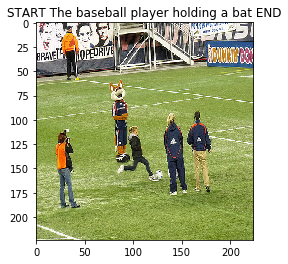

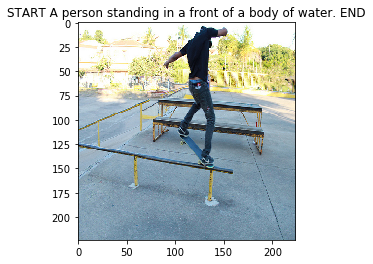

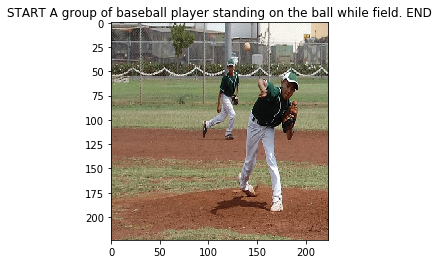

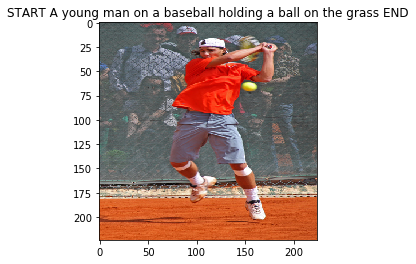

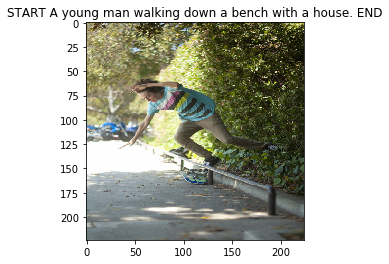

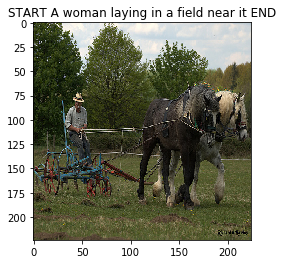

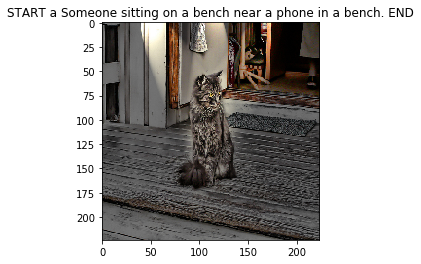

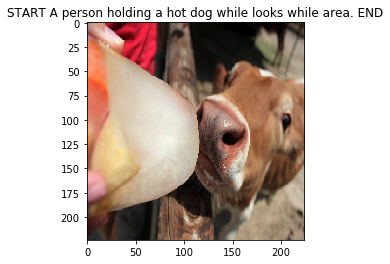

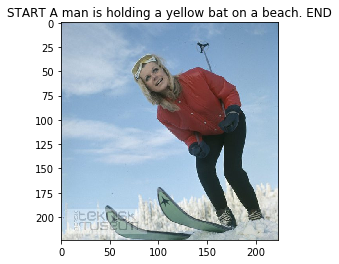

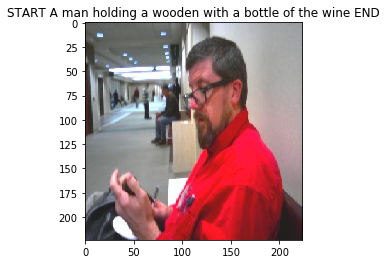

In [89]:
plot_predictions(images,titles = captions)